In [1]:
%matplotlib inline

# Experiment with Topic Modeling Large Datasets Then Filtering

For Page Two of RecoHub we want to topic model a months worth of Recommender searches. Our current models have trained on the last month.

This experiment looks at the effect of training on longer durations of Recommender search history (the previous 1 to 12 months), for a single domain group (*vSphere 6.5*) and then filtering the results to the previous month.

### Methodology:

* Retrieve all *vSphere 6.5* entries for the last 360 days (for regular sampling a "month" is actually 30 days)
* Observe the distribution of distance to the 4th nearest neighbours of each point (as calculated via cosine similarity). Using this values for the DBSCAN hyperparameter, epsilon, is selected for each number of months.
* Train clusters on the full samples of each 30, 60, ..., 360 days. Then filter down to only the most recent 30 days.
* Quantify the quality of the clusters retrieved and output the results to text files for qualitative analysis.

## Input data

In [47]:
import os
import sys
sys.path.append('..')

from scripts import corpora


In [44]:
import pandas as pd
from numpy import bincount
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
    
    
def get_metrics(classifications, cluster_ids):
    homogeneity_score = metrics.homogeneity_score(classifications, cluster_ids)
    completeness_score = metrics.completeness_score(classifications, cluster_ids)
    v_measure_score = metrics.v_measure_score(classifications, cluster_ids)
    return homogeneity_score, completeness_score, v_measure_score

# Taken (and modified) from dbscan-topic-modeling notebook
class DBSCANDensityClusterer(object):
    
    def __init__(self, eps, min_samples=5, min_df=2, max_df=0.1, ngram_range=(1, 1)):
        self.corpus = None
        self.min_samples = min_samples
        # self.model.labels_ are the cluster IDs, in the order of the input data
        self.model = DBSCAN(eps=eps, min_samples=self.min_samples, metric='cosine', n_jobs=-1)
        self.vectorizer = TfidfVectorizer(stop_words='english', min_df=min_df,
                                          max_df=max_df, ngram_range=ngram_range)

        self.homogeneity_score = None
        self.completeness_score = None
        self.v_measure_score = None
        self.end_date = None
        self.one_month_ago_dt = None
        self.all_dates = []
        self.all_bodies = []
        self.all_links = []
        self.recent_dates = []
        self.recent_bodies = []
        self.recent_links = []
        self.recent_labels = []
        self.dt_format = '%Y-%m-%dT%H:%M:%SZ'
        self.all_homogeneity_score = None
        self.all_completeness_score = None
        self.all_v_measure_score = None
        self.recent_homogeneity_score = None
        self.recent_completeness_score = None
        self.recent_v_measure_score = None
        self.recent_pruned_homogeneity_score = None
        self.recent_pruned_completeness_score = None
        self.recent_pruned_v_measure_score = None
        self.all_pruned_homogeneity_score = None
        self.all_pruned_completeness_score = None
        self.all_pruned_v_measure_score = None
    
    def cluster(self, corpus):
        self.corpus = corpus
        self.all_bodies = [doc['body'] for doc in corpus]
        self.all_dates = [datetime.strptime(doc['date'], self.dt_format) for doc in corpus]
        self.all_links = [doc['links_to_solution'][0] for doc in corpus]
        self.end_date = max(self.all_dates)
        self.one_month_ago_dt = self.end_date - timedelta(days=30)
        vectors = self.vectorizer.fit_transform(self.all_bodies)
        self.model.fit(vectors)
        self.calculate_metrics()
        
    def n_clusters(self):
        # self.model.label_ == 1 means unclustered
        # 0 <= self.model.label_ <= N - 1 are the cluster indices
        return max(self.model.labels_) + 1
        
    def get_cluster(self, cluster_id):
        return [document for index, document in enumerate(self.corpus)
                if self.model.labels_[index] == cluster_id]

    def get_recent_cluster(self, cluster_id):
        
        return  [document for index, document in enumerate(self.corpus)
                 if self.model.labels_[index] == cluster_id
                 and self.all_dates[index] <= self.end_date
                 and self.all_dates[index] > self.one_month_ago_dt
                ]
    
    def _filter_recent_queries(self):
        """After modelling, retain only those queries in the final month"""
        self.recent_dates = [date for index, date in enumerate(self.all_dates)
                             if self.all_dates[index] <= self.end_date
                             and self.all_dates[index] > self.one_month_ago_dt
                            ]
        self.recent_bodies = [body for index, body in enumerate(self.all_bodies)
                              if self.all_dates[index] <= self.end_date
                              and self.all_dates[index] > self.one_month_ago_dt
                             ]
        self.recent_links = [link for index, link in enumerate(self.all_links)
                              if self.all_dates[index] <= self.end_date
                              and self.all_dates[index] > self.one_month_ago_dt
                            ]
        self.recent_labels = [label for index, label in enumerate(self.model.labels_)
                              if self.all_dates[index] <= self.end_date
                              and self.all_dates[index] > self.one_month_ago_dt
                             ]
                              
    def _filter_clustered_results(self, all_links, all_labels):
        """Remove the unclustered results from the links and labels (classification and cluster)
        lists. This means that the quantitative metrics can be calculated on only the clustered
        queries.

        """
        filtered_links = [link for index, link in enumerate(all_links) if all_labels[index] != -1]
        filtered_labels = [label for label in all_labels if label != -1]

        return filtered_links, filtered_labels

    def valid_recent_clusters(self, recent_filtered_labels):
        """Find the indices of all clusters found from the full data range that
        have a minimum of self.min_samples in the most recent month of data
        
        """
        cluster_counts = bincount(recent_filtered_labels)
        return [
            index for index, value in enumerate(cluster_counts) if value >= self.min_samples
        ]
        

    def calculate_metrics(self):
        """Calculate the metrics for the clusters for full time range and only
        the most recent month (trained on the full time range, but only including
        the documents in the resulting clusters from the most recent months)
        
        """
        self._filter_recent_queries()

        all_clustered_links, all_clustered_labels = self._filter_clustered_results(
            self.all_links, self.model.labels_
        )
        recent_clustered_links, recent_clustered_labels = self._filter_clustered_results(
            self.recent_links, self.recent_labels
        )

        # Calculate metrics for all questions that were clustered from the full sample
        self.all_homogeneity_score = metrics.homogeneity_score(all_clustered_links, all_clustered_labels)
        self.all_completeness_score = metrics.completeness_score(all_clustered_links, all_clustered_labels)
        self.all_v_measure_score = metrics.v_measure_score(all_clustered_links, all_clustered_labels)

        # Calculate metrics for all clustered questions in the most recent month
        # These samples also include all clusters originally detected, even those
        # where there are fewer elements in the most recent month than min_sample
        self.recent_homogeneity_score = metrics.homogeneity_score(
            recent_clustered_links, recent_clustered_labels
        )
        self.recent_completeness_score = metrics.completeness_score(
            recent_clustered_links, recent_clustered_labels
        )
        self.recent_v_measure_score = metrics.v_measure_score(
            recent_clustered_links, recent_clustered_labels
        )

        # Now calculate the same metrics only including the clusters that are large enough
        # in the most recent month
        valid_recent_clusters = self.valid_recent_clusters(recent_clustered_labels)
        all_pruned_labels = [label for label in all_clustered_labels 
                             if label in valid_recent_clusters]
        all_pruned_links = [link for index, link in enumerate(all_clustered_links)
                            if all_clustered_labels[index] in valid_recent_clusters]
        recent_pruned_labels = [label for label in recent_clustered_labels
                                if label in valid_recent_clusters]
        recent_pruned_links = [link for index, link in enumerate(recent_clustered_links)
                               if recent_clustered_labels[index] in valid_recent_clusters]
        
        self.recent_pruned_homogeneity_score = metrics.homogeneity_score(recent_pruned_links, recent_pruned_labels)
        self.recent_pruned_completeness_score = metrics.completeness_score(recent_pruned_links, recent_pruned_labels)
        self.recent_pruned_v_measure_score = metrics.v_measure_score(recent_pruned_links, recent_pruned_labels)
        self.all_pruned_homogeneity_score = metrics.homogeneity_score(all_pruned_links, all_pruned_labels)
        self.all_pruned_completeness_score = metrics.completeness_score(all_pruned_links, all_pruned_labels)
        self.all_pruned_v_measure_score = metrics.v_measure_score(all_pruned_links, all_pruned_labels)

In [4]:
# Define a function to make a Solr query:

# Filter - based on presence of links_to_solution
# Filter - based on being within 12 months
# Filter - based on domain (being in domain group)
# Filter - based on object_type = "QUESTION"

import pysolr


solr_core_name = 'NEW_PRD-vmware-sfkm'
solr_host = 'localhost'
solr_port = '8983'

def _get_solr(solr_core_name, solr_host, solr_port):
    """A function to return a pysolr Solr object
    
    :param solr_core_name: Str
    :param solr_host: Str
    :param solr_port: Str
    
    """
    solr_url = 'http://{}:{}/solr/{}'.format(solr_host, solr_port, solr_core_name)
    return pysolr.Solr(solr_url, timeout=30)

def _get_solr_docs(solr, query, fq=[], sort='', batch_size='100', fl='*', limit=None):
    """Helper function to execute and combine the specified query
    
    :param solr: pysolr.Solr object instance
    :param query: (Str) query string, e.g. '*:*'
    :param fq: List(Str) field query strings to query by, e.g. 'field_name: [* TO *]'
    :param sort: Str fields to sort results by, e.g 'field_name: [asc|dec]'.
        Default is no sorting.
    :param batch_size: Str(Int) number of results to return per batch, default is
        '100'.
    :param fl: Str comma separated list of fields to return for each object,
        default is all.
    :param limit: Str(Int) maximum number of result to return, default is no limit.
    
    """
    cursorMark = '*'
    count = 0
    while (True):
        results = solr.search(query,
                              fq=fq,
                              cursorMark=cursorMark,
                              fl=fl,
                              sort=sort,
                              rows=batch_size)

        for result in results:
            if 'date' in result:
                try:
                    result['date'] = parser.parse(result['date'])
                except Exception:
                    pass
            yield result

            count += 1
            if limit and count >= limit:
                return
        if cursorMark == results.nextCursorMark:
            return
        cursorMark = results.nextCursorMark

def get_domain_queries(domains,
                       date_start='*',
                       date_end='*',
                       fields_to_exist=None,
                       fl='*',
                       batch_size='100',
                       sort='date desc,id asc',
                       limit=None):
    """This class will return a generator.
    
    Intrinsically, this will limit results to only 'object_type:QUESTION'
    
    :param domains: List(Str) domains to query for
    :param date_start: Str lower bound to query for datewise, this should
        be of format '%Y-%m-%dT%H:%M:%SZ'. The default value is '*', which
        is the equivalent of no lower bound for the date range.
    :param date_end: Str upper bound to query for datewise, this should
        be of format '%Y-%m-%dT%H:%M:%SZ'. The default value is '*', which
        is the equivalent of no upper bound for the date range.
    :param fields_to_exist: List(Str) fields that should be present on objects
        that are returned. For each field, the fq string is 'field_name': [* TO *].
        Default value is none, imposing no constraints on the query.
    :param fl: Str comma separated list of fields to return in the object. Default
        value is all fields.
    :param batch_size: Str(Int) the number of results to return in each batch.
    :param sort: Str the fields to sort the output results by, can be multiple,
        with each field looking as follow: 'field_name [asc|desc]'. Additional
        fields are comma separated. The default value is to sort by date, with
        the most recent entries first. Those entries with identical date will then
        be sorted by object ID.
    :param limit: The limit of results to be returned. By default there is no limit.
    
    """
    global solr_core_name, solr_host, solr_port
    
    query='*:*'
    
    domains_query = '+(domain:"' + '" domain:"'.join(domains) + '")'
    fq_query = 'object_type:QUESTION, ' + domains_query

    fq = [fq_query]
    fq.append('date:[{} TO {}]'.format(date_start, date_end))

    if fields_to_exist:
        fq.extend(['{}:[* TO *]'.format(field) for field in fields_to_exist])

    solr = _get_solr(solr_core_name, solr_host, solr_port)

    return _get_solr_docs(solr,
                          query,
                          fl=fl,
                          fq=fq,
                          sort=sort,
                          batch_size=batch_size,
                          limit=limit)



In [5]:
# Retrieve the results from the most recent ~12 months (360 days for more regular month size)

from datetime import datetime, timedelta


vsphere_65_domains = ['VMware vCenter Server Appliance 6.5',
                      'VMware vCenter Server 6.5',
                      'VMware Update Manager 6.5',
                      'VMware vSphere ESXi 6.5',
                      'VMware vCenter Server Appliance 6.7',
                      'VMware vSphere ESXi 6.7',
                      'VMware Update Manager 6.7',
                      'VMware vCenter Server 6.7']

solr_fl = 'title,id,links_to_solution,doc_type,domain,date,body'
datetime_string_format = '%Y-%m-%dT%H:%M:%SZ'

# Find the most recent vSphere 6.5 query saved in Solr
most_recent_vsphere_65_query_gen = get_domain_queries(vsphere_65_domains,
                                                  fields_to_exist=['links_to_solution'],
                                                  fl='id,date',
                                                  sort='date desc,id asc',
                                                  limit=1)

most_recent_query_date_str = next(most_recent_vsphere_65_query_gen)['date']

# Create a string of the date 360 days ago 
most_recent_query_datetime = datetime.strptime(most_recent_query_date_str, datetime_string_format)
one_year_ago = most_recent_query_datetime - timedelta(days=360)
one_year_ago_str = one_year_ago.strftime(datetime_string_format)

# Get all domain specific queries within the specifed date range
vsphere_65_queries_12_months_gen = get_domain_queries(vsphere_65_domains,
                                                      date_start=one_year_ago_str,
                                                      date_end=most_recent_query_date_str,
                                                      fields_to_exist=['links_to_solution'],
                                                      fl=solr_fl)

vsphere_65_queries_12_months = [doc for doc in vsphere_65_queries_12_months_gen
                                if 'body' in doc and len(doc['links_to_solution']) == 1]

print('There are {} vSphere 6.5 queries in the relevant 360 days.'.format(len(vsphere_65_queries_12_months)))

There are 4270 vSphere 6.5 queries in the relevant 360 days.


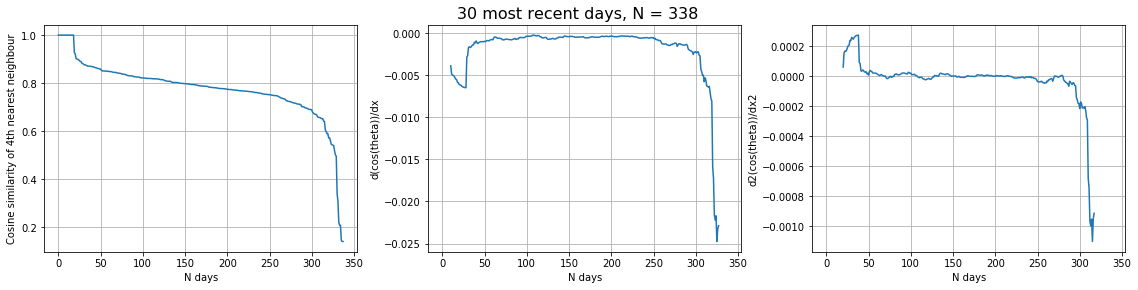

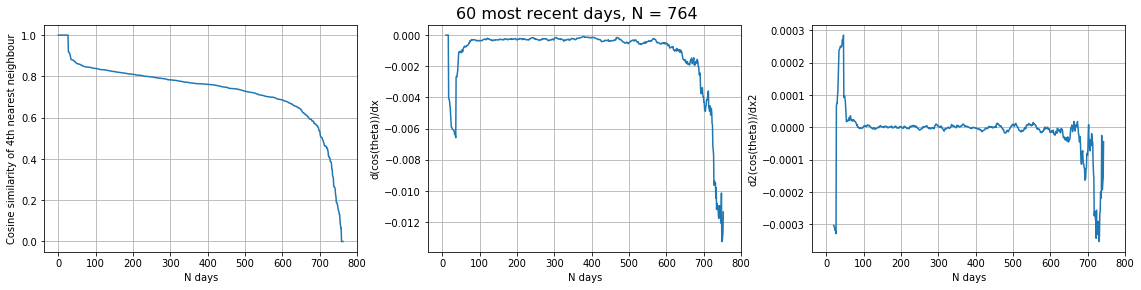

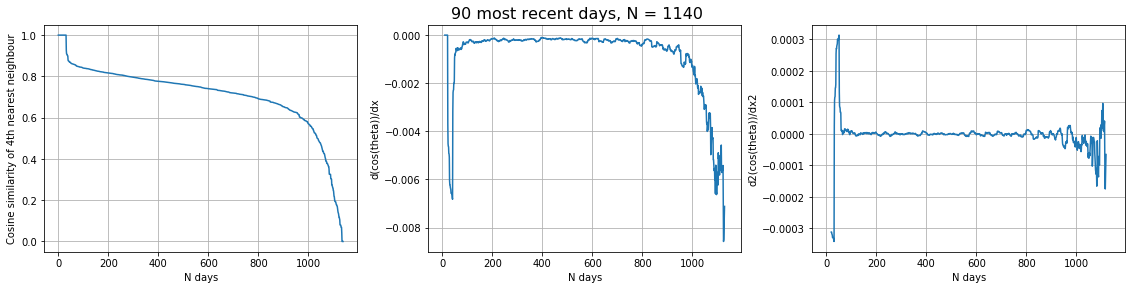

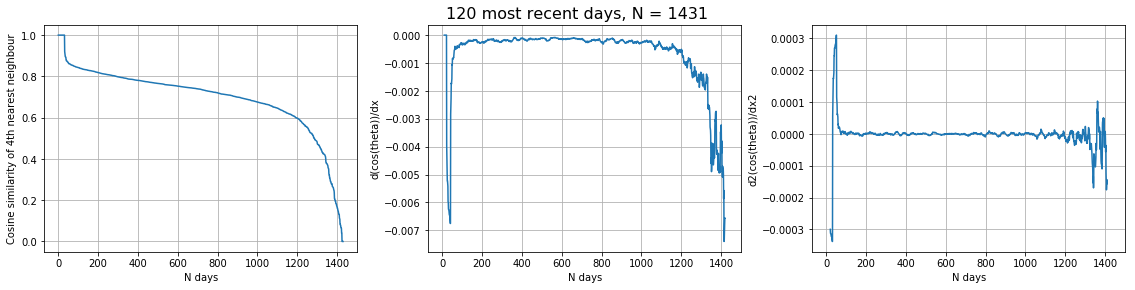

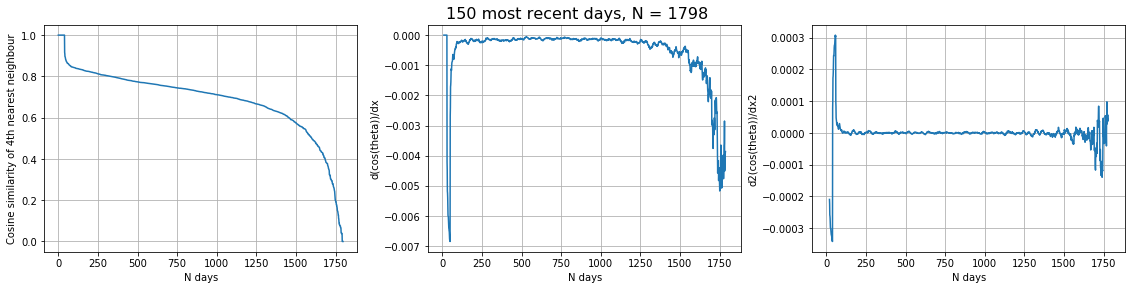

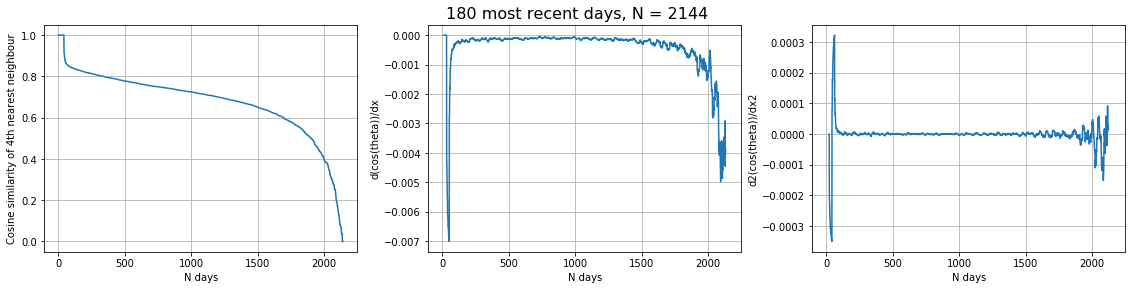

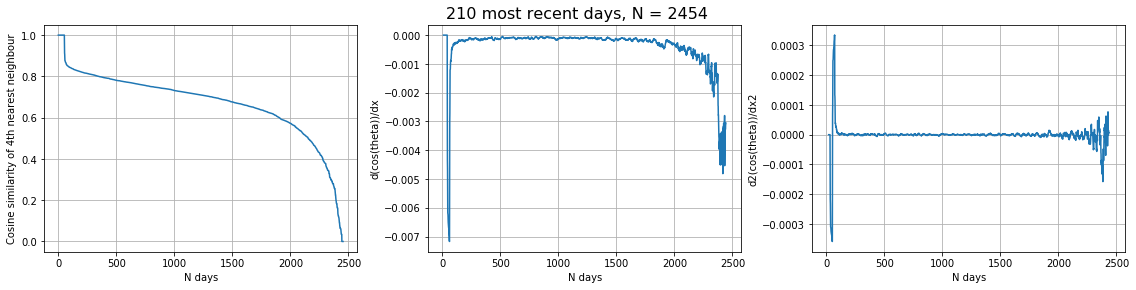

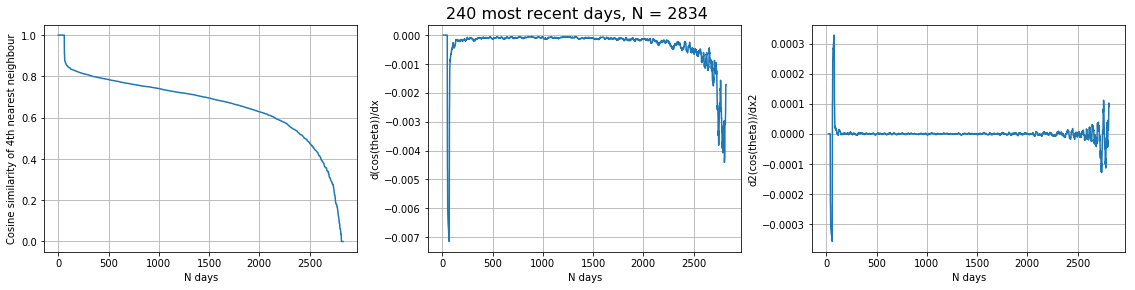

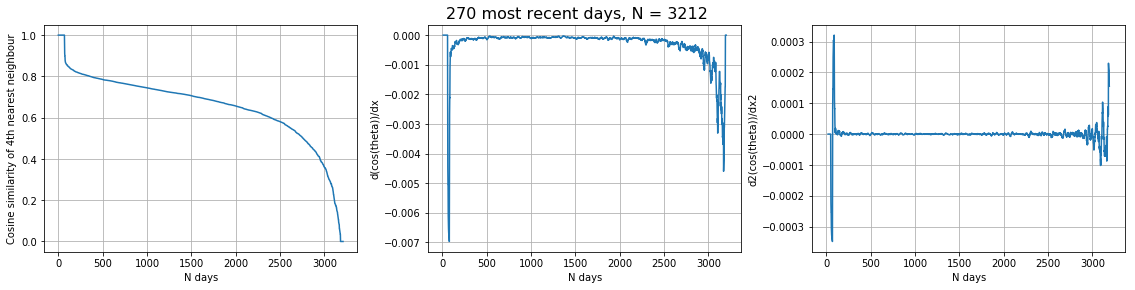

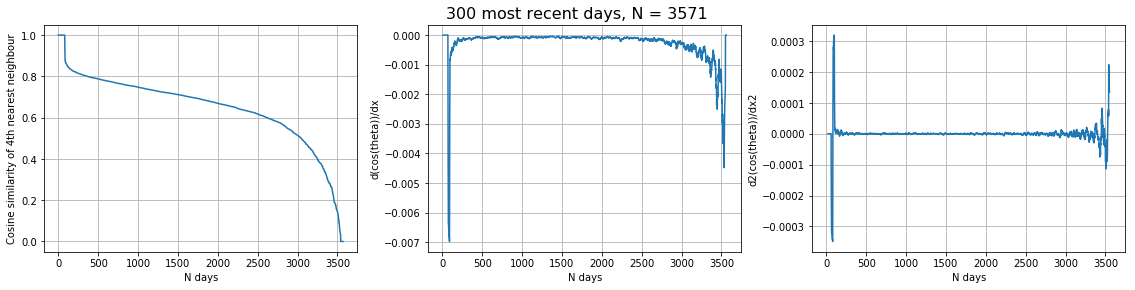

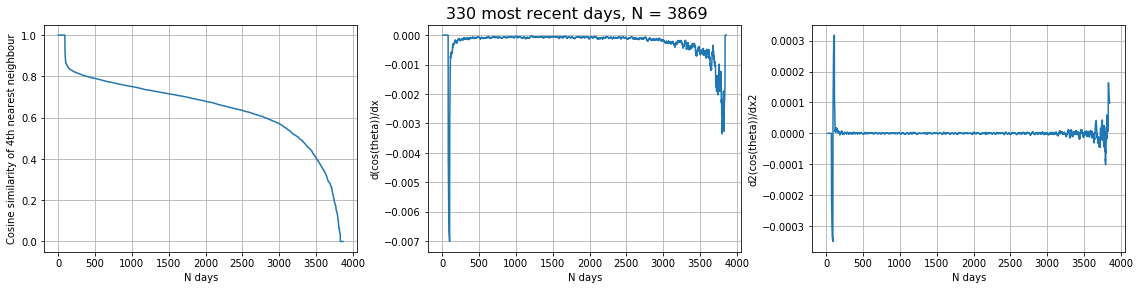

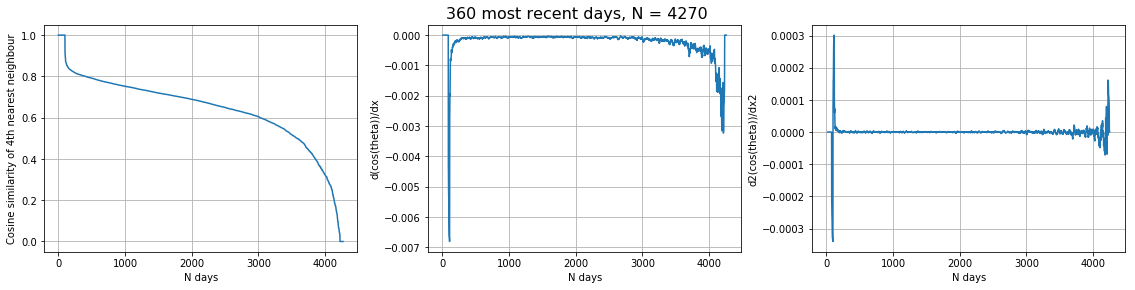

In [38]:
# Tune epsilon by eye:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt


vectorizer = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.1)
k = 4
interval_len = 30
interval_days = range(1 * interval_len, 13 * interval_len, interval_len)

for interval in interval_days:
    old_query_time = most_recent_query_datetime - timedelta(days=interval)
    
    # Filter the solutions:
    filtered_bodies = [search['body'] for search in vsphere_65_queries_12_months
                       if datetime.strptime(search['date'], datetime_string_format) > old_query_time]

    # Vectorize the search bodies
    vectors = vectorizer.fit_transform(filtered_bodies)

    # Create the adjacency matrix for all question pairs
    # where, cosine similarity = sum(A_i, B_i) / (sqrt(sum(A_i^2)) x sqrt(sum(B_i^2)))
    distances = pairwise_distances(vectors, metric='cosine')
    
    # find the fourth nearest neighbour for all points:
    k_dists = sorted([sorted(distances[point])[k] for point in range(len(distances))], reverse=True)
    
    # Find the first and second derivatives of the curve for epsilon
    deriv_len = 10
    x_deriv = range(deriv_len, len(k_dists) - deriv_len)
    k_dist_deriv = [
        (k_dists[ind + deriv_len] - k_dists[ind - deriv_len]) / float(2 * deriv_len)
        for ind in range(deriv_len, len(k_dists) - deriv_len)
    ]
    x_2nd_deriv = range(2 * deriv_len, len(k_dists) - (2 * deriv_len))
    k_dist_2nd_deriv = [
        (k_dist_deriv[ind + deriv_len] - k_dist_deriv[ind - deriv_len]) / float(2 * deriv_len)
        for ind in range(deriv_len, len(k_dist_deriv) - deriv_len) 
    ]

    # Plot out the results
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(16, 4))
    plt.suptitle('{} most recent days, N = {}'.format(interval, len(filtered_bodies)), fontsize=16)
    plt.tight_layout(pad=2.0, w_pad=4.0, h_pad=2.5)
    axs[0].plot(k_dists)
    axs[0].set_xlabel('N days')
    axs[0].set_ylabel('Cosine similarity of {}th nearest neighbour'.format(k))
    axs[0].grid(linestyle='-')
    axs[1].plot(x_deriv, k_dist_deriv)
    axs[1].set_xlabel('N days')
    axs[1].set_ylabel('d(cos(theta))/dx')
    axs[1].grid(linestyle='-')
    axs[2].plot(x_2nd_deriv, k_dist_2nd_deriv)
    axs[2].set_xlabel('N days')
    axs[2].set_ylabel('d2(cos(theta))/dx2')
    axs[2].grid(linestyle='-')

In [48]:
tuned_epsilons = [0.65, 0.60, 0.575, 0.55, 0.50, 0.50, 0.50, 0.475, 0.45, 0.40, 0.425, 0.40]
dbscan_iterations = [{'days': interval_days[index], 'epsilon': tuned_epsilon} 
                     for index, tuned_epsilon in enumerate(tuned_epsilons)]

for dbscan_iteration in dbscan_iterations:
    print('Processing DBSCAN for most recent {} days'.format(dbscan_iteration['days']))
    unigram_dir = '../output/dbscan/vsphere-6.5-comparison/unigram/last-{}-days'.format(dbscan_iteration['days'])
    ngram_dir = '../output/dbscan/vsphere-6.5-comparison/ngram/last-{}-days'.format(dbscan_iteration['days'])
    dbscan_unigram_cluster_csv = unigram_dir + '/clusters.csv'
    dbscan_unigram_document_all_csv = unigram_dir + '/documents-{}-days.csv'.format(dbscan_iteration['days'])
    dbscan_unigram_document_recent_csv = unigram_dir + '/documents_recent.csv'
    dbscan_ngram_cluster_csv = ngram_dir + '/clusters.csv'
    dbscan_ngram_document_all_csv = ngram_dir + '/documents-{}-days.csv'.format(dbscan_iteration['days'])
    dbscan_ngram_document_recent_csv = ngram_dir + '/documents-{}-days.csv'.format(dbscan_iteration['days'])

    # Check for directory existance, if not there, create it
    if not os.path.isdir(unigram_dir):
        os.makedirs(unigram_dir)

    if not os.path.isdir(ngram_dir):
        os.makedirs(ngram_dir)

    # Filter the solutions:
    old_query_time = most_recent_query_datetime - timedelta(days=dbscan_iteration['days'])
    queries = [search for search in vsphere_65_queries_12_months
               if datetime.strptime(search['date'], datetime_string_format) > old_query_time]
    
    # Instantiate a DBSCAN cluster object with predetermined epsilon value
    dbscan_clusterer = DBSCANDensityClusterer(eps=dbscan_iteration['epsilon'])
    dbscan_clusterer.cluster(queries)

    # Compile and output clusters
    dbscan_clusters = pd.DataFrame(
        [{'Cluster ID': cluster_id,
          '{} day size'.format(dbscan_iteration['days']): len(dbscan_clusterer.get_cluster(cluster_id)),
          '30 day size': len(dbscan_clusterer.get_recent_cluster(cluster_id))
         } for cluster_id in range(dbscan_clusterer.n_clusters())]
    )
    dbscan_clusters = dbscan_clusters[
        ['Cluster ID', '{} day size'.format(dbscan_iteration['days']), '30 day size']
    ]
    dbscan_clusters.to_csv(dbscan_unigram_cluster_csv, index=False)

    # Compile and output documents in the clusters (full range)
    dbscan_all_documents = pd.DataFrame([{'Cluster ID': cluster_id, 'Search': body}
                                         for cluster_id in range(dbscan_clusterer.n_clusters())
                                         for body in dbscan_clusterer.get_cluster(cluster_id)])
    dbscan_all_documents.to_csv(dbscan_unigram_document_all_csv, index=False)
    
    # Compile and output documents in the clusters (most recent 30 days)
    dbscan_recent_documents = pd.DataFrame([{'Cluster ID': cluster_id, 'Search': body}
                                            for cluster_id in range(dbscan_clusterer.n_clusters())
                                            for body in dbscan_clusterer.get_recent_cluster(cluster_id)])
    dbscan_recent_documents.to_csv(dbscan_unigram_document_recent_csv, index=False)

    # perform clustering using n-grams (unigrams and bigrams)
    dbscan_clusterer_ngram = DBSCANDensityClusterer(eps=0.5, ngram_range=(1, 2))
    dbscan_clusterer_ngram.cluster(queries)

    # Compile and output clusters (unigram and bigram)
    dbscan_clusters_ngram = pd.DataFrame(
        [{'Cluster ID': cluster_id,
          '{} day size'.format(dbscan_iteration['days']): len(dbscan_clusterer_ngram.get_cluster(cluster_id)),
          '30 day size': len(dbscan_clusterer_ngram.get_recent_cluster(cluster_id))
         } for cluster_id in range(dbscan_clusterer_ngram.n_clusters())]
    )
    dbscan_clusters_ngram = dbscan_clusters_ngram[
        ['Cluster ID', '{} day size'.format(dbscan_iteration['days']), '30 day size']
    ]
    dbscan_clusters_ngram.to_csv(dbscan_ngram_cluster_csv, index=False)
    
    # Compile and output documents in the clusters (unigram and bigram, full range)
    dbscan_all_documents_ngram = pd.DataFrame([{'Cluster ID': cluster_id, 'Search': body}
                                               for cluster_id in range(dbscan_clusterer_ngram.n_clusters())
                                               for body in dbscan_clusterer_ngram.get_cluster(cluster_id)])
    dbscan_all_documents.to_csv(dbscan_ngram_document_all_csv, index=False)

    # Compile and output documents in the clusters (unigram and bigram, most recent 30 days)
    dbscan_recent_documents_ngram = pd.DataFrame([{'Cluster ID': cluster_id, 'Search': body}
                                                  for cluster_id in range(dbscan_clusterer_ngram.n_clusters())
                                                  for body
                                                  in dbscan_clusterer_ngram.get_recent_cluster(cluster_id)])
    dbscan_recent_documents.to_csv(dbscan_ngram_document_all_csv, index=False)

    # Save the sample size, number of clusters, homogeneity score, completeness score and v-measure
    dbscan_iteration['total_docs'] = len(queries)
    dbscan_iteration['Nclusters_unigram_all'] = len(dbscan_clusters)
    dbscan_iteration['Nclusters_unigram_pruned'] = len(
        [cluster_id for cluster_id in range(dbscan_clusterer.n_clusters())
         if len(dbscan_clusterer.get_recent_cluster(cluster_id)) >= 5]
    )
    dbscan_iteration['unigram_h_all_clusters_all_time'] = dbscan_clusterer.all_homogeneity_score
    dbscan_iteration['unigram_c_all_clusters_all_time'] = dbscan_clusterer.all_completeness_score
    dbscan_iteration['unigram_v_all_clusters_all_time'] = dbscan_clusterer.all_v_measure_score
    dbscan_iteration['unigram_h_pruned_clusters_all_time'] = dbscan_clusterer.all_pruned_homogeneity_score
    dbscan_iteration['unigram_c_pruned_clusters_all_time'] = dbscan_clusterer.all_pruned_completeness_score
    dbscan_iteration['unigram_v_pruned_clusters_all_time'] = dbscan_clusterer.all_pruned_v_measure_score
    dbscan_iteration['unigram_h_pruned_clusters_recent'] = dbscan_clusterer.recent_pruned_homogeneity_score
    dbscan_iteration['unigram_c_pruned_clusters_recent'] = dbscan_clusterer.recent_pruned_completeness_score
    dbscan_iteration['unigram_v_pruned_clusters_recent'] = dbscan_clusterer.recent_pruned_v_measure_score

    dbscan_iteration['Nclusters_ngram_all'] = len(dbscan_clusters)
    dbscan_iteration['Nclusters_ngram_pruned'] = len(
        [cluster_id for cluster_id in range(dbscan_clusterer.n_clusters())
         if len(dbscan_clusterer_ngram.get_recent_cluster(cluster_id)) >= 5]
    )
    dbscan_iteration['ngram_h_all_clusters_all_time'] = dbscan_clusterer_ngram.all_homogeneity_score
    dbscan_iteration['ngram_c_all_clusters_all_time'] = dbscan_clusterer_ngram.all_completeness_score
    dbscan_iteration['ngram_v_all_clusters_all_time'] = dbscan_clusterer_ngram.all_v_measure_score
    dbscan_iteration['ngram_h_pruned_clusters_all_time'] = dbscan_clusterer_ngram.all_pruned_homogeneity_score
    dbscan_iteration['ngram_c_pruned_clusters_all_time'] = dbscan_clusterer_ngram.all_pruned_completeness_score
    dbscan_iteration['ngram_v_pruned_clusters_all_time'] = dbscan_clusterer_ngram.all_pruned_v_measure_score
    dbscan_iteration['ngram_h_pruned_clusters_recent'] = dbscan_clusterer_ngram.recent_pruned_homogeneity_score
    dbscan_iteration['ngram_c_pruned_clusters_recent'] = dbscan_clusterer_ngram.recent_pruned_completeness_score
    dbscan_iteration['ngram_v_pruned_clusters_recent'] = dbscan_clusterer_ngram.recent_pruned_v_measure_score

print('Processing complete')

Processing DBSCAN for most recent 30 days
Processing DBSCAN for most recent 60 days
Processing DBSCAN for most recent 90 days
Processing DBSCAN for most recent 120 days
Processing DBSCAN for most recent 150 days
Processing DBSCAN for most recent 180 days
Processing DBSCAN for most recent 210 days
Processing DBSCAN for most recent 240 days
Processing DBSCAN for most recent 270 days
Processing DBSCAN for most recent 300 days
Processing DBSCAN for most recent 330 days
Processing DBSCAN for most recent 360 days
Processing complete


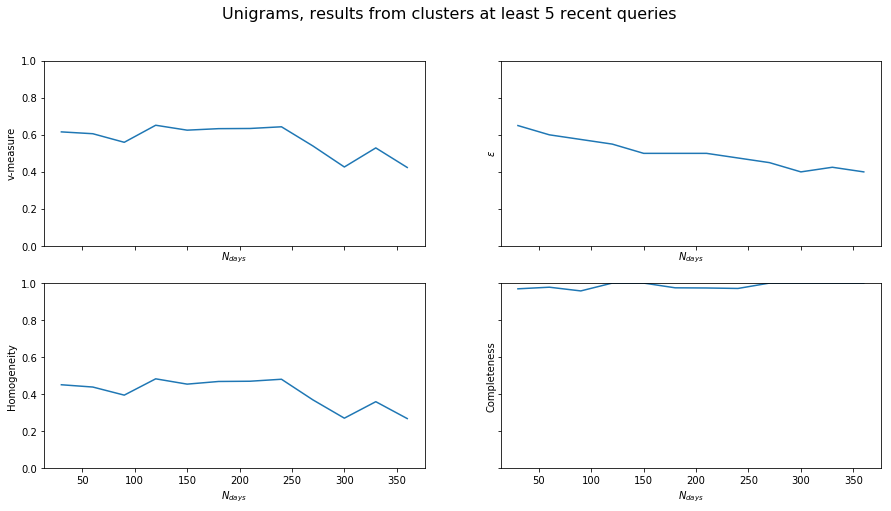

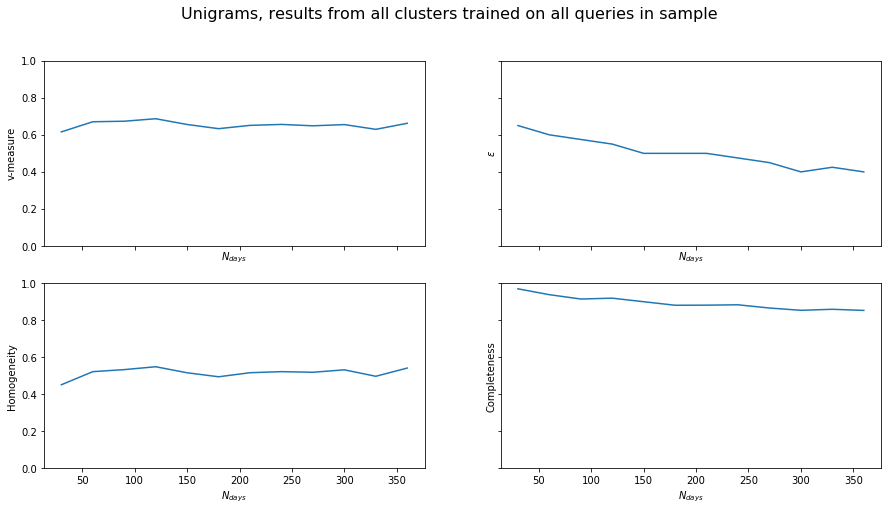

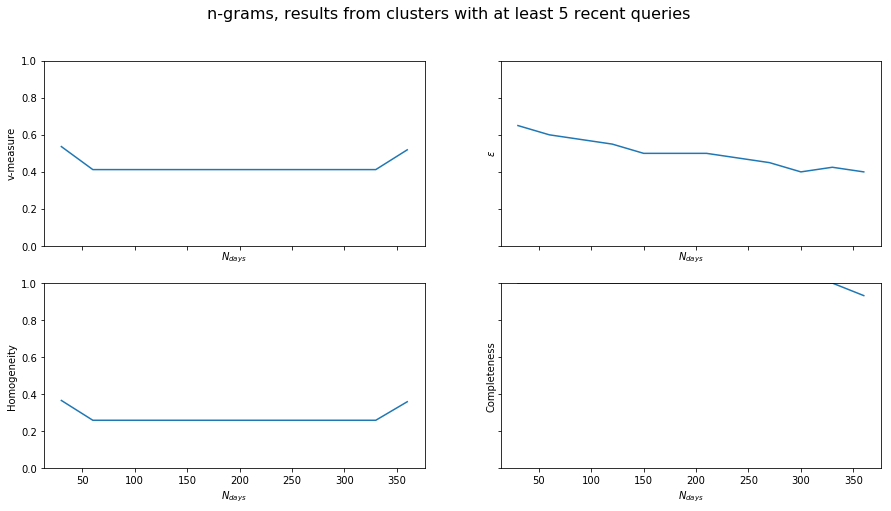

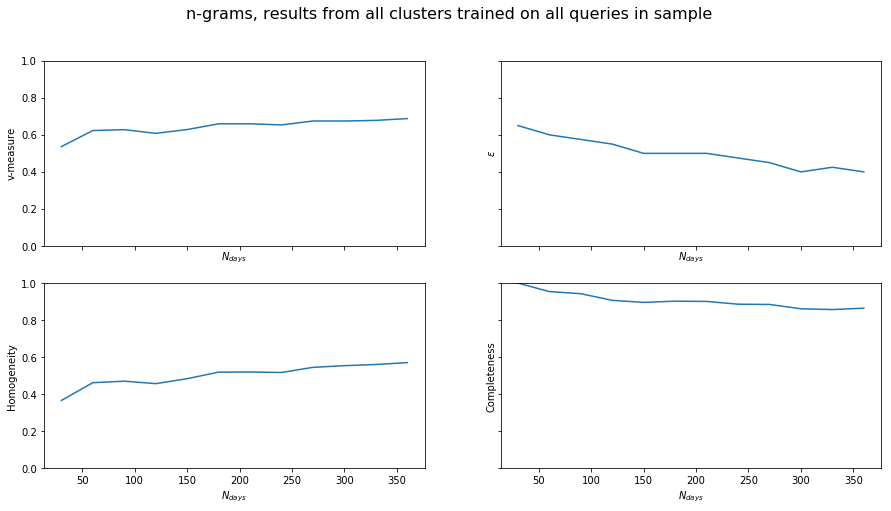

In [46]:
# Plot out the results:

# Load results into a pandas DataFrame
results_df = pd.DataFrame(dbscan_iterations)

plot_dicts = [
    {'title': 'Unigrams, results from clusters at least 5 recent queries',
     'v_measure': 'unigram_v_pruned_clusters_recent',
     'epsilon': 'epsilon',
     'h-score': 'unigram_h_pruned_clusters_recent',
     'c-score': 'unigram_c_pruned_clusters_recent'},
    {'title': 'Unigrams, results from all clusters trained on all queries in sample',
     'v_measure': 'unigram_v_all_clusters_all_time',
     'epsilon': 'epsilon',
     'h-score': 'unigram_h_all_clusters_all_time',
     'c-score': 'unigram_c_all_clusters_all_time'},
    {'title': 'n-grams, results from clusters with at least 5 recent queries',
     'v_measure': 'ngram_v_pruned_clusters_recent',
     'epsilon': 'epsilon',
     'h-score': 'ngram_h_pruned_clusters_recent',
     'c-score': 'ngram_c_pruned_clusters_recent'},
    {'title': 'n-grams, results from all clusters trained on all queries in sample',
     'v_measure': 'ngram_v_all_clusters_all_time',
     'epsilon': 'epsilon',
     'h-score': 'ngram_h_all_clusters_all_time',
     'c-score': 'ngram_c_all_clusters_all_time'}
]

for plot_dict in plot_dicts:
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 7.5))
    plt.suptitle(plot_dict['title'], fontsize=16)
    axs[0, 0].plot(results_df['days'], results_df[plot_dict['v_measure']])
    axs[0, 0].set_xlabel('$N_{days}$')
    axs[0, 0].set_ylabel('v-measure')
    axs[0, 0].set_ylim(0, 1)

    axs[0, 1].plot(results_df['days'], results_df[plot_dict['epsilon']])
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].set_xlabel('$N_{days}$')
    axs[0, 1].set_ylabel('$\epsilon$')

    axs[1, 0].plot(results_df['days'], results_df[plot_dict['h-score']])
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].set_xlabel('$N_{days}$')
    axs[1, 0].set_ylabel('Homogeneity')

    axs[1, 1].plot(results_df['days'], results_df[plot_dict['c-score']])
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].set_xlabel('$N_{days}$')
    axs[1, 1].set_ylabel('Completeness')
    plt.show()

# Conclusions:

Firstly, note that all figures in from the cell above have the smaller sample (e.g. only most recent results) to the left of each panel.

The baseline, quantified performance of DBSCAN is the homogeniety, completeness and v-measure of the sample when considering only the most recent 30 days. Effectively, at this point, the metrics are equal both before and after filtering the full sample, as the full sample *is* the most recent sample. As we can see, for unigrams, *v ~= 0.6* and for unigrams and bigrams combined, *v ~= 0.5* for the most recent month. After this, when increasing the duration over which clusters are obtained but calculating metrics only including those queries from the most recent 30 days, *v* is generally is lower for the unigram and bigram combined approach, and (at best) remains approximately constant until about 210 days (~7 months) after which it reduces. This indicates that, at the most optimistic, the additional data used in creating the clusters does not significantly improve the quantified quality of the clusters as whittled down to the most recent 30 days.

Additional analysis, as displayed in the second and fourth sets of plots, shows that the unigram only clusters also do not significantly improve in *v* by folding in more data when using all cluster members to calculate *v* (not just the most recent 30 days). However, the final set of figures suggests that, when using both unigrams and bigrams, *v* does improve when using more data and including all queries within the clusters to calculate *v*. This appears to be due to a greater increase in homogeneity, while there is a slight decline in completeness.